# Planar data classification with one hidden layer

It's time to build our first neural network, which will have a hidden layer. We will see a big difference between this model and the one we implemented using logistic regression. 

**We will:**
- Implement a 2-class classification neural network with a single hidden layer
- Use units with a non-linear activation function, such as tanh 
- Compute the cross entropy loss 
- Implement forward and backward propagation

## 1 - Packages ##

Let's first import all the packages that you will need during this assignment.
- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [sklearn](http://scikit-learn.org/stable/) provides simple and efficient tools for data mining and data analysis. 
- [matplotlib](http://matplotlib.org) is a library for plotting graphs in Python.
- testCases provides some test examples to assess the correctness of your functions
- planar_utils provide various useful functions used in this assignment

In [105]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
from testCases_v2 import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) # set a seed so that the results are consistent

## 2 - Dataset ##

First, let's get the dataset we will work on. The following code will load a "flower" 2-class dataset into variables `X` and `Y`.

In [106]:
X, Y = load_planar_dataset()

Visualize the dataset using matplotlib. The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. Our goal is to build a model to fit this data. In other words, we want the classifier to define regions as either red or blue.

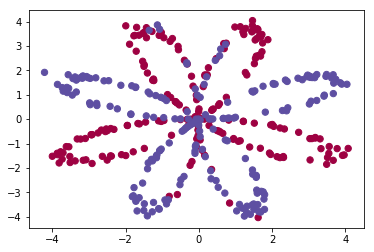

In [107]:
# Visualize the data:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral)

We have:
    - a numpy-array (matrix) X that contains your features (x1, x2)
    - a numpy-array (vector) Y that contains your labels (red:0, blue:1).

Lets first get a better sense of what our data is like. 

How many training examples do you have? In addition, what is the `shape` of the variables `X` and `Y`? 

In [108]:
shape_X = X.shape
shape_Y = Y.shape
m = len(X[0])  # training set size

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

The shape of X is: (2, 400)
The shape of Y is: (1, 400)
I have m = 400 training examples!


## 3 - Simple Logistic Regression

Before building a full neural network, lets first see how logistic regression performs on this problem. We can use sklearn's built-in functions to do that. 

In [109]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T, Y.T)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

We can now plot the decision boundary of these models. 

Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


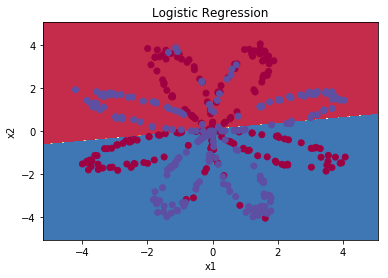

In [110]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

**Interpretation**: The dataset is not linearly separable, so logistic regression doesn't perform well. Hopefully a neural network will do better. Let's try this now! 

## 4 - Neural Network model

Logistic regression did not work well on the "flower dataset". We are going to train a Neural Network with a single hidden layer.

**Here is our model**:
<img src="images/classification_kiank.png" style="width:600px;height:300px;">

**Mathematically**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Given the predictions on all the examples, we can also compute the cost $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Reminder**: The general methodology to build a Neural Network is to:
    1. Define the neural network structure ( # of input units,  # of hidden units, etc). 
    2. Initialize the model's parameters
    3. Loop:
        - Implement forward propagation
        - Compute loss
        - Implement backward propagation to get the gradients
        - Update parameters (gradient descent)

We often build helper functions to compute steps 1-3 and then merge them into one function we call `nn_model()`. Once you've built `nn_model()` and learnt the right parameters, you can make predictions on new data.

### 4.1 - Defining the neural network structure ####

We need to define three variables:
    - n_x: the size of the input layer
    - n_h: the size of the hidden layer (set this to 4) 
    - n_y: the size of the output layer

To do so, we can use shapes of X and Y to find n_x and n_y. Also, hard code the hidden layer size to be 4.

In [111]:
def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    
    n_x = X.shape[0] # size of input layer
    n_h = 4
    n_y = Y.shape[0] # size of output layer
    return (n_x, n_h, n_y)

### 4.2 - Initialize the model's parameters ####

In [112]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """ 
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1)) 
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1)) 
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

### 4.3 - The Loop ####

We are going to implement `forward_propagation()`.

- Look above at the mathematical representation of your classifier.
- The steps you have to implement are:
    1. Retrieve each parameter from the dictionary "parameters" (which is the output of `initialize_parameters()`) by using `parameters[".."]`.
    2. Implement Forward Propagation. Compute $Z^{[1]}, A^{[1]}, Z^{[2]}$ and $A^{[2]}$ (the vector of all your predictions on all the examples in the training set).
- Values needed in the backpropagation are stored in "`cache`". The `cache` will be given as an input to the backpropagation function.

In [113]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    Z1 = W1.dot(X) + b1
    A1 = np.tanh(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = sigmoid(Z2)
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

Now that we have computed $A^{[2]}$ (in the Python variable "`A2`"), which contains $a^{[2](i)}$ for every example, we can compute the cost function as follows:

$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

- Implement `compute_cost()` to compute the value of the cost $J$.

In [114]:
def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    [Note that the parameters argument is not used in this function, 
    but the auto-grader currently expects this parameter.
    Future version of this notebook will fix both the notebook 
    and the auto-grader so that `parameters` is not needed.
    For now, please include `parameters` in the function signature,
    and also when invoking this function.]
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    
    """
    
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
    logprobs = np.multiply(np.log(A2),Y) + np.multiply(np.log(1 - A2),(1 - Y))
    cost = - np.multiply(np.sum(logprobs), 1/m)
    
    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect. 
                                    # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost

Using the cache computed during forward propagation, we can now implement backward propagation.

- Implement the function `backward_propagation()`.

Backpropagation is usually the hardest (most mathematical) part in deep learning. We'll use the six equations on the right of this slide, since you are building a vectorized implementation.  

<img src="images/grad_summary.png" style="width:600px;height:300px;">

<!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Note that $*$ denotes elementwise multiplication.
- The notation you will use is common in deep learning coding:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    
!-->

In [115]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    W1 = parameters['W1']
    W2 = parameters['W2']
        
    # Retrieve also A1 and A2 from dictionary "cache".
    A1 = cache['A1']
    A2 = cache['A2']
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    dZ2 = A2 - Y
    dW2 = np.multiply(dZ2.dot(A1.T), 1/m)
    db2 = np.multiply(np.sum(dZ2, axis = 1, keepdims = True), 1/m)
    dZ1 = np.multiply(W2.T.dot(dZ2), (1 - np.power(A1, 2)))
    dW1 = np.multiply(dZ1.dot(X.T), 1/m)
    db1 = np.multiply(np.sum(dZ1, axis = 1, keepdims = True), 1/m)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

We now need to implement the update rule. Use gradient descent. We have to use (dW1, db1, dW2, db2) in order to update (W1, b1, W2, b2).

**General gradient descent rule**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ where $\alpha$ is the learning rate and $\theta$ represents a parameter.

**Illustration**: The gradient descent algorithm with a good learning rate (converging) and a bad learning rate (diverging). Images courtesy of Adam Harley.

<img src="images/sgd.gif" style="width:400;height:400;"> <img src="images/sgd_bad.gif" style="width:400;height:400;">

In [116]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Retrieve each gradient from the dictionary "grads"
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    # Update rule for each parameter
    W1 = W1 - np.multiply(learning_rate, dW1)
    b1 = b1 - np.multiply(learning_rate, db1)
    W2 = W2 - np.multiply(learning_rate, dW2)
    b2 = b2 - np.multiply(learning_rate, db2)
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

### 4.4 - Integrate parts 4.1, 4.2 and 4.3 in nn_model() ####

We can now build our neural network model in `nn_model()`.

In [117]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
         
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2, Y, parameters)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads)
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

### 4.5 Predictions

Use our model to predict by building predict().
Use forward propagation to predict results.

**Reminder**: predictions = $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  

In [118]:
# GRADED FUNCTION: predict

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    A2, cache = forward_propagation(X, parameters)
    predictions = A2 > 0.5 
    
    return predictions

It is time to run the model and see how it performs on a planar dataset.

Cost after iteration 0: 0.693113
Cost after iteration 1000: 0.282578
Cost after iteration 2000: 0.269777
Cost after iteration 3000: 0.262318
Cost after iteration 4000: 0.241228
Cost after iteration 5000: 0.226023
Cost after iteration 6000: 0.221621
Cost after iteration 7000: 0.218907
Cost after iteration 8000: 0.216885
Cost after iteration 9000: 0.215260


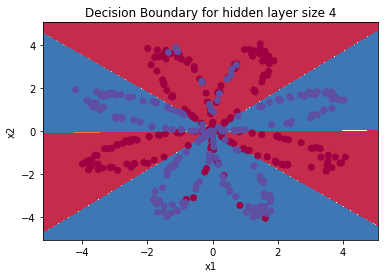

In [119]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [120]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 90%


Accuracy is really high compared to Logistic Regression. The model has learnt the leaf patterns of the flower! Neural networks are able to learn even highly non-linear decision boundaries, unlike logistic regression. 

Now, let's try out several hidden layer sizes.

### 4.6 - Tuning hidden layer size (optional/ungraded exercise) ###

We will observe different behaviors of the model for various hidden layer sizes.

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 90.5 %
Accuracy for 20 hidden units: 91.25 %
Accuracy for 50 hidden units: 91.0 %


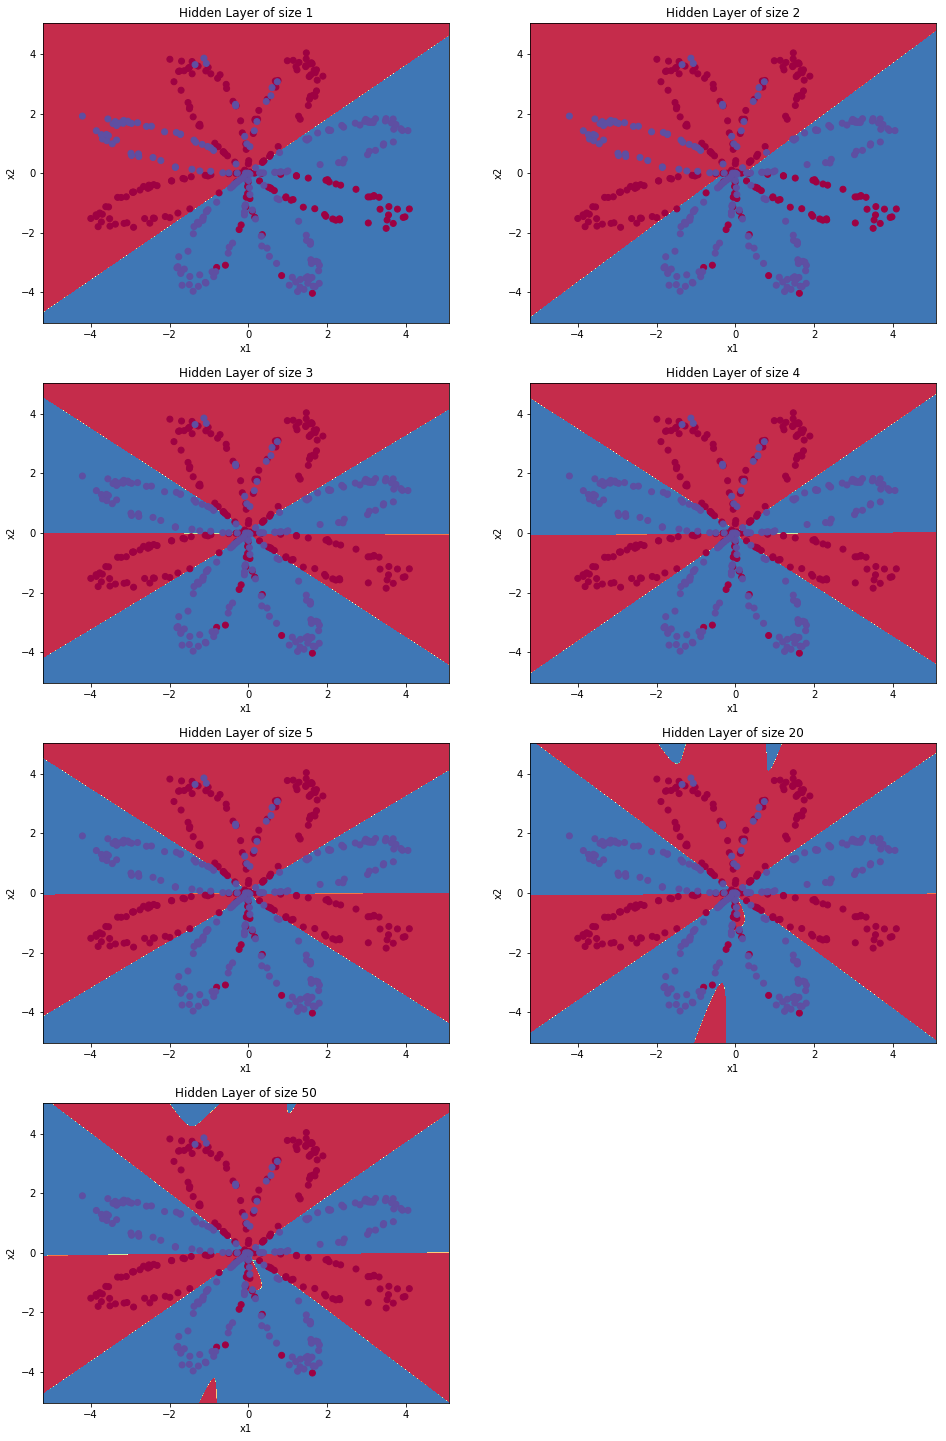

In [121]:
# This may take about 2 minutes to run

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

**Interpretation**:
- The larger models (with more hidden units) are able to fit the training set better, until eventually the largest models overfit the data. 
- The best hidden layer size seems to be around n_h = 5. Indeed, a value around here seems to  fits the data well without also incurring noticeable overfitting.

<font color='blue'>
**We've seen how to:**
- Build a complete neural network with a hidden layer
- Make a good use of a non-linear unit
- Implemented forward propagation and backpropagation, and trained a neural network
- See the impact of varying the hidden layer size, including overfitting.

Nice work! 

## 5) Performance on other datasets

If you want, you can rerun the whole notebook (minus the dataset part) for each of the following datasets.

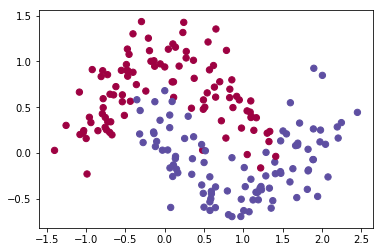

In [122]:
# Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

### START CODE HERE ### (choose your dataset)
dataset = "noisy_moons"
### END CODE HERE ###

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

Reference:
- http://scs.ryerson.ca/~aharley/neural-networks/
- http://cs231n.github.io/neural-networks-case-study/